Being conscious of our energy consumption is important for the future health of our planet. In this project, we're going to try to understand the energy usage patterns of the Boston Public Library (Central branch). The aim is to find an interpretable regression model for the library's energy consumption. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the datasets

We will be combining two datasets. The first dataset from [boston.gov](https://data.boston.gov/dataset/central-library-electricity-usage) gives energy usage information for the Boston Public Library (Central branch). The second dataset was obtained using [Meteostat's API](https://dev.meteostat.net/python/hourly.html), which gives hourly data on the weather in Boston. 

In [2]:
energy_df = pd.read_csv("data/energy_usage.csv")
weather_df = pd.read_csv("data/weather.csv")

In [3]:
energy_df['usage_datetime_end_eastern_time'] = pd.to_datetime(energy_df['usage_datetime_end_eastern_time'])

In [4]:
energy_df['date'] = energy_df['usage_datetime_end_eastern_time'].apply(lambda x:x.date())
energy_df['hour'] = energy_df['usage_datetime_end_eastern_time'].apply(lambda x:x.hour)

In [5]:
df = energy_df.groupby(['date', 'hour'])['usage_kw'].sum().reset_index()

In [6]:
def combine_date_hour(date, hour):
    return pd.Timestamp(year=date.year,
                        month=date.month,
                        day=date.day,
                        hour=hour)

In [7]:
df['time'] = df.apply(lambda x:combine_date_hour(x.date, x.hour), axis=1)

In [8]:
weather_df['time'] = pd.to_datetime(weather_df['time'])

In [9]:
df = df.merge(weather_df, on='time')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6782 entries, 0 to 6781
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      6782 non-null   object        
 1   hour      6782 non-null   int64         
 2   usage_kw  6782 non-null   float64       
 3   time      6782 non-null   datetime64[ns]
 4   temp      6782 non-null   float64       
 5   dwpt      6782 non-null   float64       
 6   rhum      6782 non-null   float64       
 7   prcp      6782 non-null   float64       
 8   snow      0 non-null      float64       
 9   wdir      6782 non-null   float64       
 10  wspd      6782 non-null   float64       
 11  wpgt      0 non-null      float64       
 12  pres      6782 non-null   float64       
 13  tsun      0 non-null      float64       
 14  coco      6782 non-null   float64       
dtypes: datetime64[ns](1), float64(12), int64(1), object(1)
memory usage: 794.9+ KB


In [11]:
df = df.drop(columns=['date', 'snow', 'wpgt', 'tsun'], axis=1)

# Splitting the data

Since the data we have is timed-based, in order to avoid data leakage, we will split the dataset into training, validation, and test sets based on time. The earliest 60% of data points will belong to the training set. The next 20% is the validation set, and the last 20% will be the test set. 

In [12]:
n = len(df)
m = n//5
X_train = df[:-2*m]
X_valid = df[-2*m:-m]
X_test =  df[-m:]

# Data exploration

In this part, we'll try to understand the dataset more. We want to understand the relationship between each of the variables. This will help us decipher what would be useful in predicting energy usage. Then this information can help us decide what kinds of model to use and the architecture of the model. 

In [13]:
X_train.describe()

,hour,usage_kw,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
count,4070.000000,4070.000000,4070,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000,4070.000000
mean,11.290909,11918.425496,2023-05-12 03:27:57.051597056,13.300295,6.638624,67.323833,0.151769,193.310319,17.024889,1014.419705,3.771007
min,0.000000,511.200000,2023-01-13 00:00:00,-22.800000,-35.000000,13.000000,0.000000,0.000000,0.000000,989.400000,1.000000
25%,5.000000,9547.200000,2023-03-11 01:15:00,5.600000,-1.100000,53.000000,0.000000,100.000000,11.200000,1009.700000,2.000000
50%,11.000000,12708.000000,2023-05-13 13:30:00,13.900000,7.200000,70.000000,0.000000,200.000000,16.600000,1014.200000,3.000000
75%,17.000000,13851.000000,2023-07-12 04:45:00,21.100000,15.700000,84.000000,0.000000,280.000000,22.300000,1019.600000,4.000000
max,23.000000,16941.600000,2023-09-03 05:00:00,31.700000,23.800000,100.000000,21.800000,360.000000,51.800000,1034.900000,18.000000
std,7.009308,2820.412598,NaN,9.261588,10.271840,20.358662,0.892995,102.410593,7.531453,7.562320,2.567572


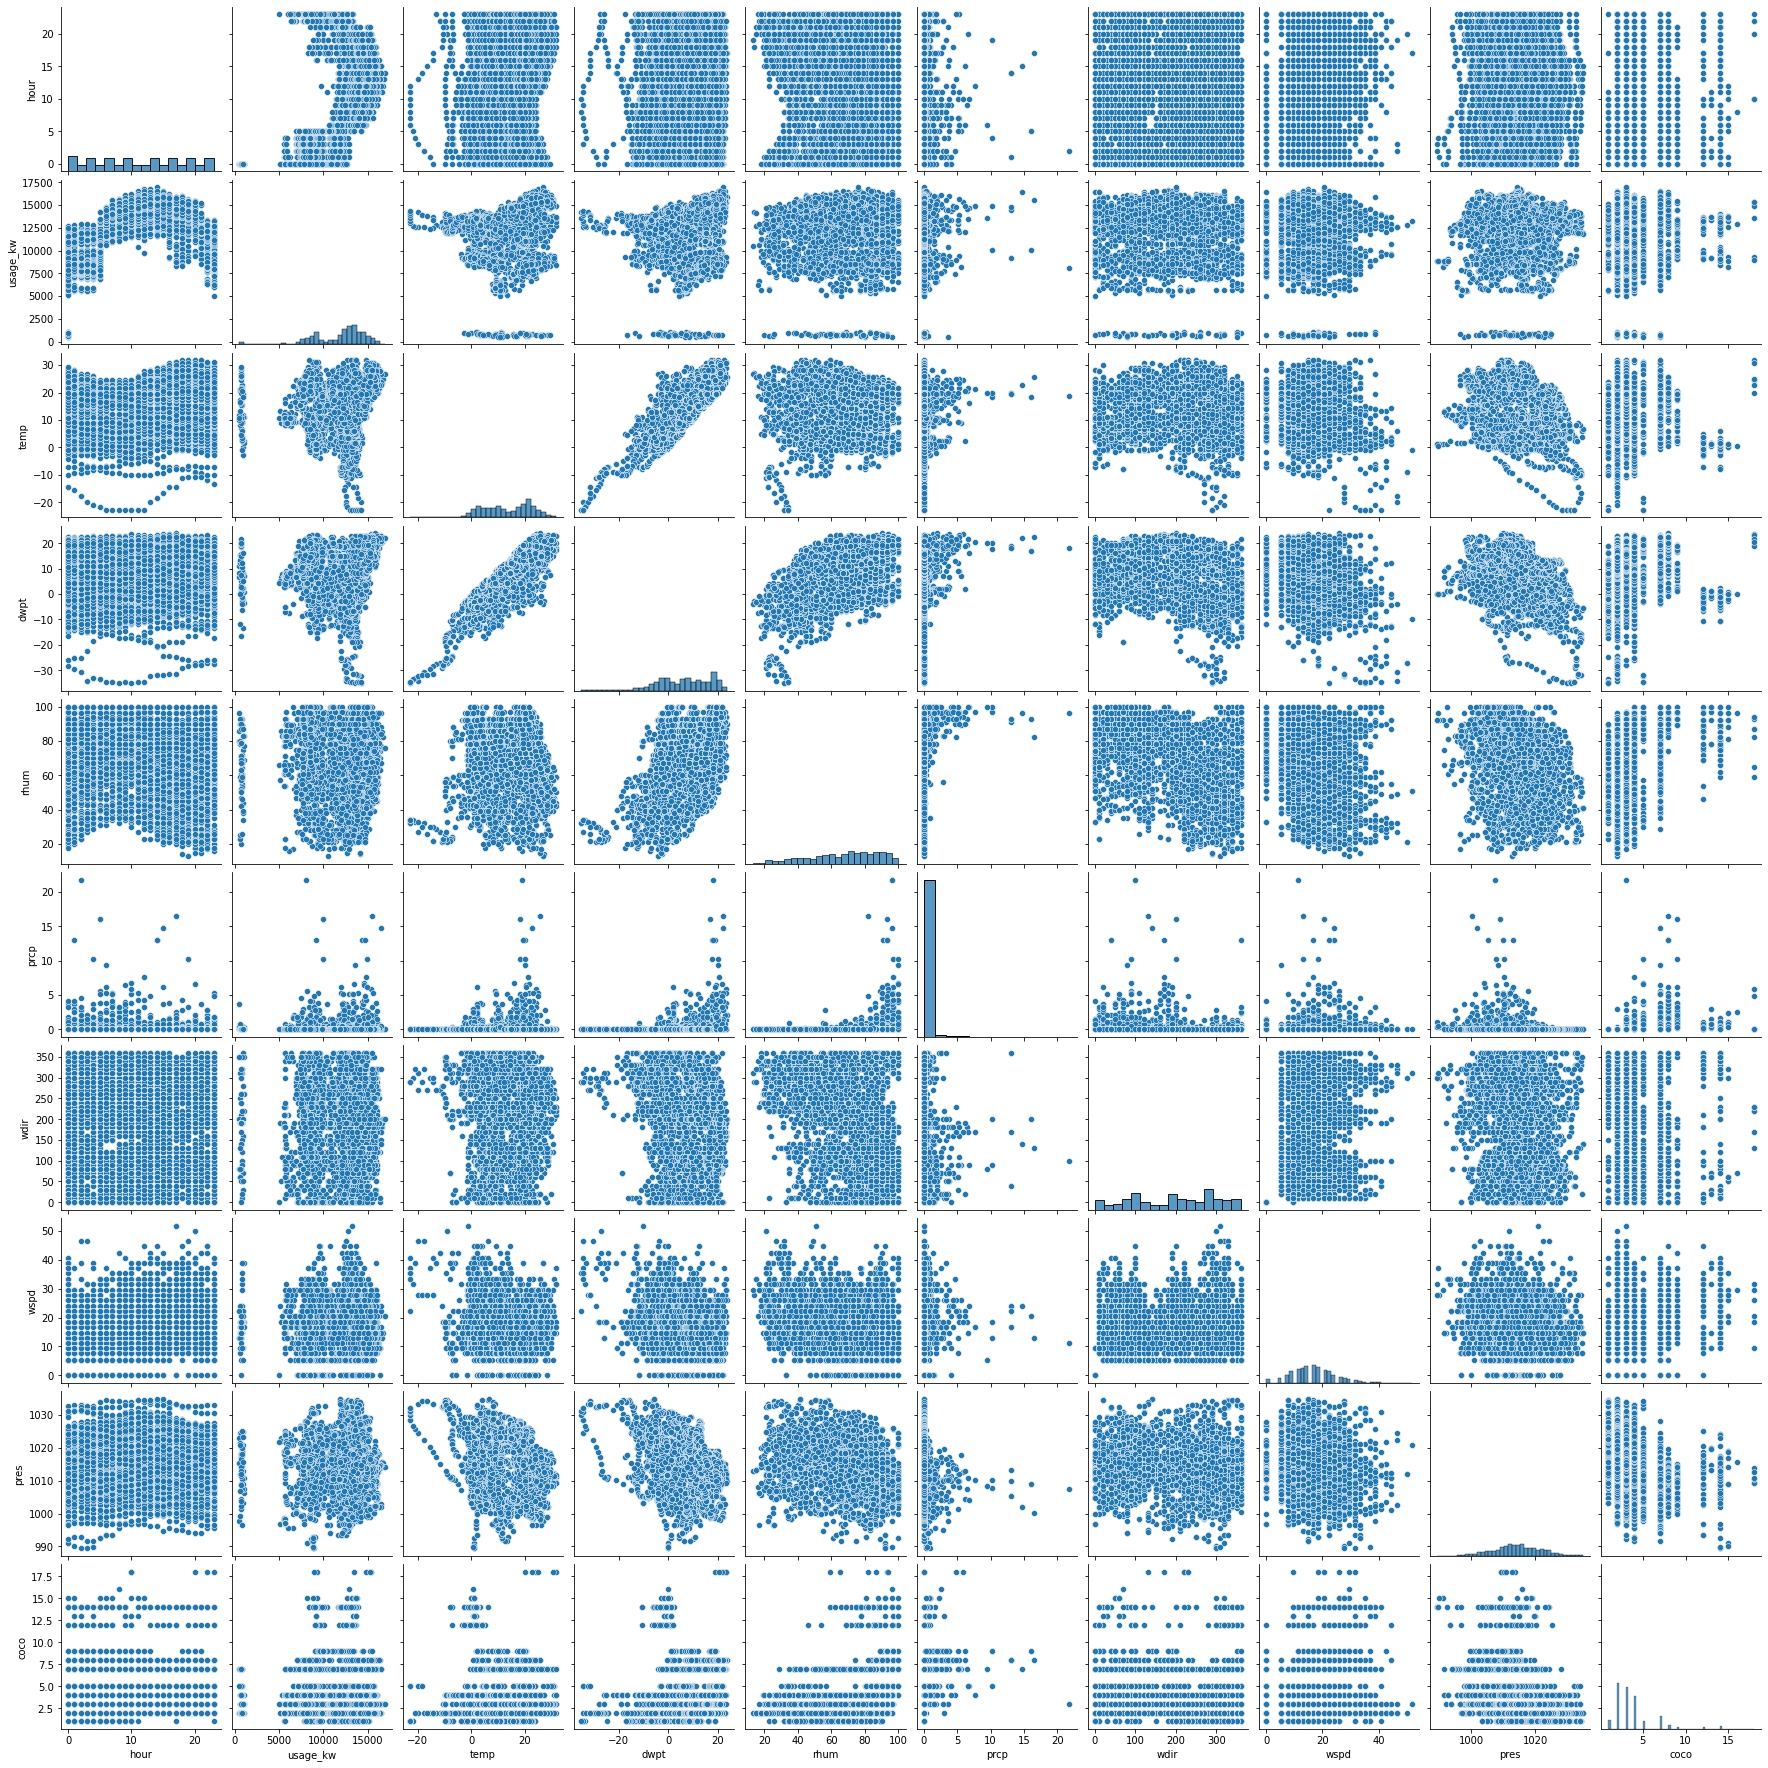

In [84]:
sns.pairplot(X_train)

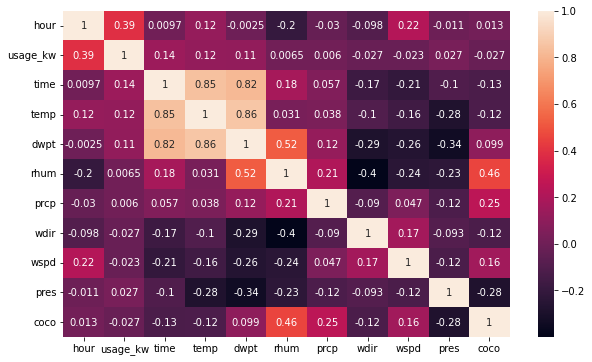

In [88]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

The hourly energy usage does not have a strong linear correlation with any of the other variables. There is a nonlinear relationship between energy and hour though. Let's try to capture the relationship between the energy usage and the hour. 

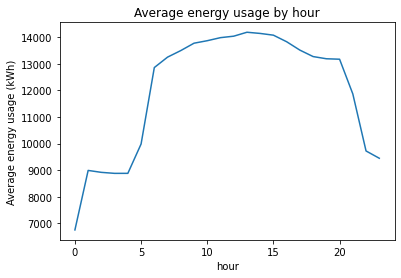

In [93]:
X_train.groupby('hour')['usage_kw'].mean().plot()
plt.ylabel('Average energy usage (kWh)')
plt.title("Average energy usage by hour")
plt.show()


We see that the average energy is lowest at midnight and highest around noon. If we convert hour into a cyclic variable using cosine, then hopefully there will be a linear relationship between the transformed hour variable and the energy usage.

In [18]:
X_train.loc[:,'cos_hour'] = np.cos(np.pi*X_train['hour']/12)

C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\1651895075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'cos_hour'] = np.cos(np.pi*X_train['hour']/12)


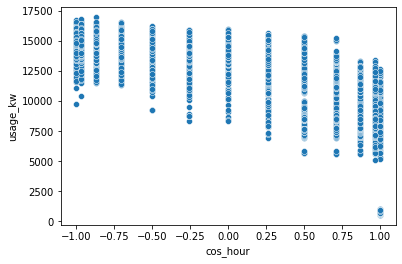

In [98]:
sns.scatterplot(X_train, x='cos_hour', y='usage_kw')
plt.show()

In [100]:
print(f"'cos_hour' and 'usage_kw' have a correlation of {X_train['cos_hour'].corr(X_train['usage_kw']): .4f}.")

'cos_hour' and 'usage_kw' have a correlation of -0.7213.


Let's try to find some relationships between the weather and energy usage. Maybe temperature and energy usage are correlated if we separate by month.

In [104]:
X_train.loc[:,'month'] = X_train['time'].apply(lambda x:x.month)

C:\Users\bliu9\AppData\Local\Temp\ipykernel_12180\295646637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'month'] = X_train['time'].apply(lambda x:x.month)


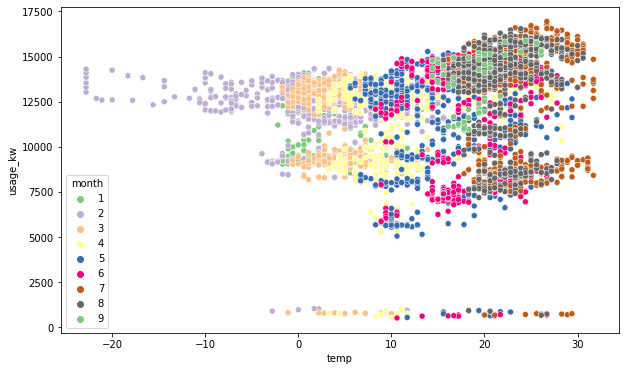

In [116]:
plt.figure(figsize=(10,6))
sns.scatterplot(X_train, x='temp', y='usage_kw', hue='month', palette='Accent')
plt.show()

We see that temperature is still not very strongly correlated with energy usage even even when we account for the month. This is probably due to the fact that energy usage is high both for extremely hot and extremely cold temperatures. 

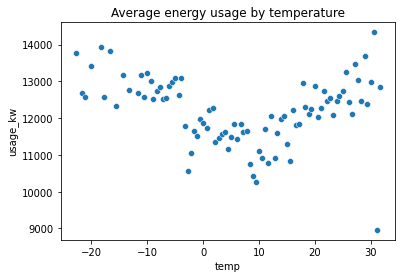

In [140]:
sns.scatterplot(X_train.groupby('temp')['usage_kw'].mean())
plt.title("Average energy usage by temperature")
plt.show()

From the plot above, we see that the relationship between temperature and energy usage appears to be quadratic.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse

In [162]:
slr = LinearRegression()

In [163]:
slr.fit(np.array(X_train['cos_hour']).reshape(-1,1), X_train['usage_kw'])

LinearRegression()

In [21]:
X_valid.loc[:,'cos_hour'] = np.cos(np.pi*X_valid['hour']/12)

C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\1374806433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.loc[:,'cos_hour'] = np.cos(np.pi*X_valid['hour']/12)


In [283]:
y_pred = slr.predict(np.array(X_valid['cos_hour']).reshape(-1,1))
rmse(X_valid['usage_kw'], y_pred)

2124.3454799322553

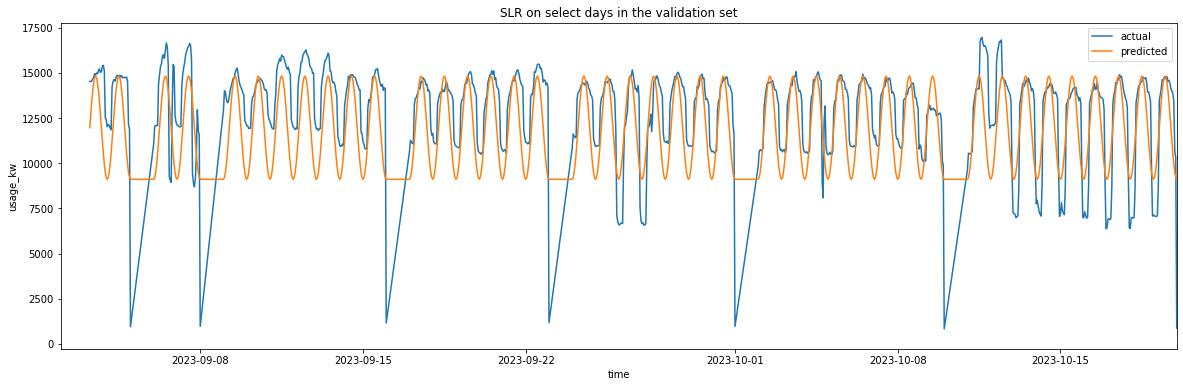

In [284]:
plt.figure(figsize=(20,6))
sns.lineplot(X_valid, x='time', y='usage_kw', label='actual')
sns.lineplot(x=X_valid['time'], y=y_pred, label='predicted')
plt.xlim(19602,19650)
plt.title('SLR on select days in the validation set')
plt.show()

The RMSE is already smaller than the standard deviation of the hourly energy usage. Now let's try to modify the linear regression model by adding in the temperature data. 

In [15]:
mlr0 = LinearRegression()

In [16]:
X_train['temp_sq'] = X_train['temp']**2
X_valid['temp_sq'] = X_valid['temp']**2

C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\3125232320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['temp_sq'] = X_train['temp']**2
C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\3125232320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['temp_sq'] = X_valid['temp']**2


In [19]:
mlr0.fit(X_train[['cos_hour', 'temp', 'temp_sq']], X_train['usage_kw'])

LinearRegression()

In [22]:
y_pred = mlr0.predict(X_valid[['cos_hour', 'temp', 'temp_sq']])

In [251]:
rmse(X_valid['usage_kw'], y_pred)

1972.8950391004255

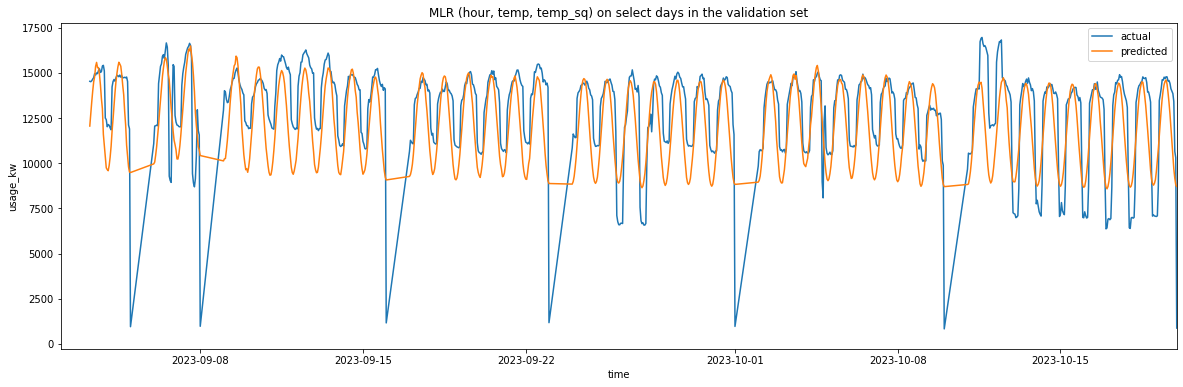

In [282]:
plt.figure(figsize=(20,6))
sns.lineplot(X_valid, x='time', y='usage_kw', label='actual')
sns.lineplot(x=X_valid['time'], y=y_pred, label='predicted')
plt.xlim(19602,19650)
plt.title('MLR (hour, temp, temp_sq) on select days in the validation set')
plt.show()

The MLR model accounting for temperature does slightly better than the SLR model by trying to fit the variations in the peaks and valleys, but the model sometimes does not want to deviate from the baseline cosine curve that accounts for the hour. 

Let's try to see if we can find some explanation for the variation in energy usage that's unaccounted for by this model.

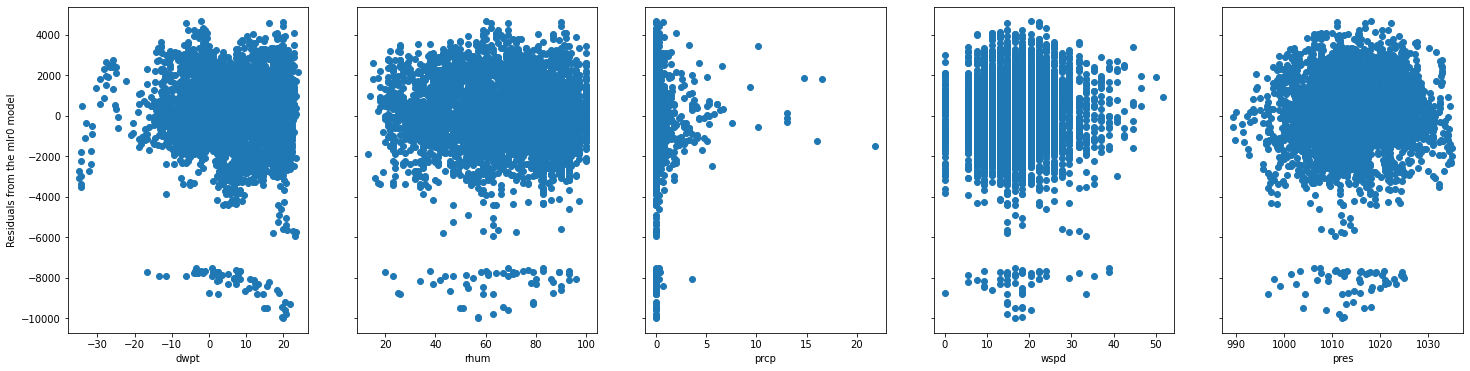

In [268]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(25,6))
cols = ['dwpt', 'rhum', 'prcp', 'wspd', 'pres']
for i in range(5):
    axs[i].scatter(x=X_train[cols[i]], 
                   y=X_train['usage_kw'] - mlr0.predict(X_train[['cos_hour', 'temp', 'temp_sq']]))
    axs[i].set_xlabel(cols[i])
axs[0].set_ylabel('Residuals from the mlr0 model')
plt.show()

In [267]:
pd.concat([pd.DataFrame(mlr0.predict(X_train[['cos_hour', 'temp', 'temp_sq']]), columns=['residual']), X_train[cols]], axis=1).corr()

,residual,dwpt,rhum,prcp,wspd,pres
residual,1.000000,0.153100,0.025702,0.006142,-0.067388,0.001579
dwpt,0.153100,1.000000,0.523224,0.123472,-0.264729,-0.337469
rhum,0.025702,0.523224,1.000000,0.208994,-0.242238,-0.233634
prcp,0.006142,0.123472,0.208994,1.000000,0.047220,-0.120990
wspd,-0.067388,-0.264729,-0.242238,0.047220,1.000000,-0.124312
pres,0.001579,-0.337469,-0.233634,-0.120990,-0.124312,1.000000


The remaining variables don't seem to be linearly correlated with the residual, so they are likely not going to explain much of the variation in energy use. There's a weak linear correlation between the dew point and the residual, so let's try adding that to our linear regression model.

In [269]:
mlr1 = LinearRegression()

In [270]:
mlr1.fit(X_train[['cos_hour', 'temp', 'temp_sq', 'dwpt']], X_train['usage_kw'])

LinearRegression()

In [286]:
y_pred = mlr1.predict(X_valid[['cos_hour', 'temp', 'temp_sq', 'dwpt']])
rmse(X_valid['usage_kw'], y_pred)

1974.860181517861

The RMSE on the validation set went up, which is not a good sign.

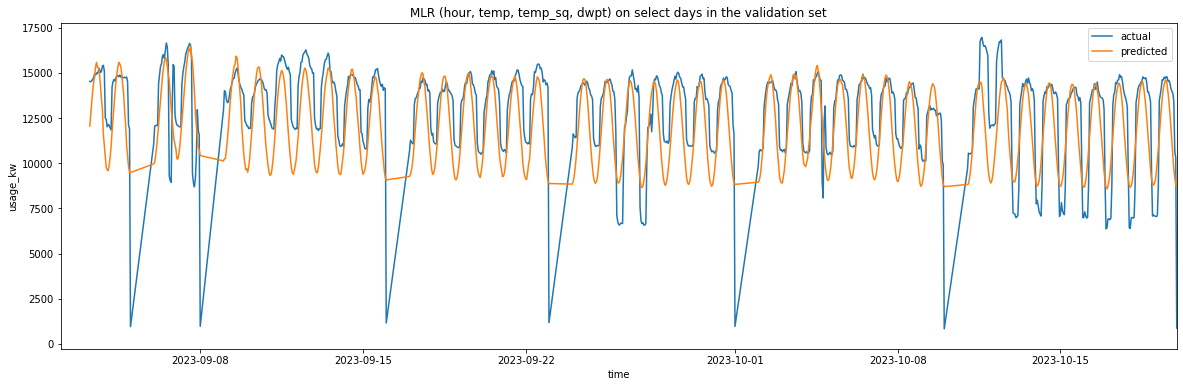

In [288]:
plt.figure(figsize=(20,6))
sns.lineplot(X_valid, x='time', y='usage_kw', label='actual')
sns.lineplot(x=X_valid['time'], y=y_pred, label='predicted')
plt.xlim(19602,19650)
plt.title('MLR (hour, temp, temp_sq, dwpt) on select days in the validation set')
plt.show()

In [291]:
print(f"The coefficient for dew point in this model is {mlr1.coef_[-1]:.4f}.")

The coefficient for dew point in this model is -6.4197.


Since the coefficient for dew point is small, we decide to go with the multiple linear regression model that does not include dew point. 

In [28]:
mlr0.coef_, mlr0.intercept_

(array([-2894.78976322,   -49.4427016 ,     4.10279905]), 11544.024685871367)

The regression model we chose is: $$y = -2894.79\cos\left(\frac{\pi h}{12}\right) - 49.44T + 4.103T^2 + 11544.025, $$
where $y$ is the energy usage for the hour in kWh, $h$ is the hour of the day on a 24 hour scale, and $T$ is the temperature in degrees Celcius. 

We may complete the square for the quadratic in $T$ to make more sense of the equation. We would get $$y = -2894.79\cos\left(\frac{\pi h}{12}\right) + 4.103(T-6.025)^2 + 11395.084.$$

From this form of the equation, we can see that there is a difference of 2894.79 kWh between midnight and noon if everything else is held constant and also that the energy usage is lowest at 6.025 degrees Celcius (42.845 degrees Fahrenheit) and temperatures away from 6.025 degrees Celcius on either side would increase the energy cost quadratically.

# Predictions on the test set

Let's also see how the model performs on the test set. 

In [25]:
X_test['cos_hour'] = np.cos(np.pi*X_test['hour']/12)

C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\2065631265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cos_hour'] = np.cos(np.pi*X_test['hour']/12)


In [26]:
X_test['temp_sq'] = X_test['temp']**2

C:\Users\bliu9\AppData\Local\Temp\ipykernel_19748\967660533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['temp_sq'] = X_test['temp']**2


In [27]:
y_pred = mlr0.predict(X_test[['cos_hour', 'temp', 'temp_sq']])
rmse(X_test['usage_kw'], y_pred)

2206.842412920248

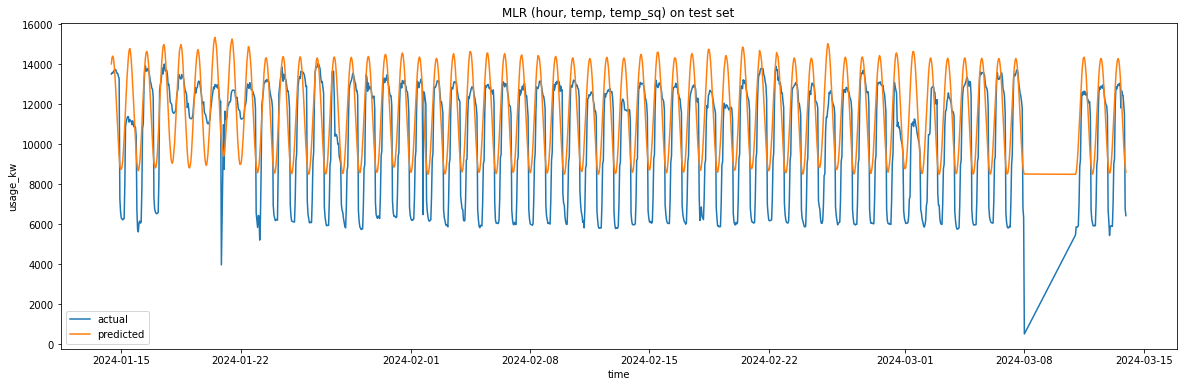

In [29]:
plt.figure(figsize=(20,6))
sns.lineplot(X_test, x='time', y='usage_kw', label='actual')
sns.lineplot(x=X_test['time'], y=y_pred, label='predicted')
plt.title('MLR (hour, temp, temp_sq) on test set')
plt.show()

It looks like the model does pretty well on the test set. It tends to overestimate the energy usage. We suspect that the periodic underestimates are from timepoints in the night.

In [307]:
X_test[X_test['usage_kw'] < 8000]['hour'].unique()

array([22, 23,  0,  1,  2,  3,  4,  5, 21, 17,  6,  7], dtype=int64)

During this time period, the only hours where the library has used less than 8000 kWh of energy are during the night. 

Overall, the model $y = -2894.79\cos\left(\frac{h}{12}\right) + 4.103(T-6.025)^2 + 11395.084$ does a good job explaining energy usage. It explains the cyclic nature of energy usage throughout each day. It also describes how temperature affects energy usage with more extreme temperatures adding to the energy consumption quadratically. 